### 1. Automatic Differentiation (Reverse Mode, Dynamic Computational Graph):  
   By using `Tensor` + Operator Overloading + `backward()`, compute gradients of inputs/parameters for model output `F(x)`.

### 2. Integrated Gradients (IG) Attribution:  
   Calculate the contribution of each element to the scalar output for any input (scalar/vector/matrix).  
   - If the model is implemented using custom `Tensor` operations → Use **AD** for gradients (Fast)  
   - If the model is a standard physical function or black-box function → Use **FD (Finite Difference)** for gradients (General)

### 3. Which operations support Automatic Differentiation (AD)?

In this implementation, **only when an operation meets the following two points** is it supported by automatic differentiation (can participate in the computation graph and backpropagate):
1) The forward pass of the operation generates a new `Tensor out` and records the dependency `out._prev`  
2) A backward propagation closure `out._backward` is implemented for the operation (defining how to pass `out.grad` back to parent nodes)

**Supported Differentiable Operators (Graph Construction + Backpropagation)**
- Matrix Multiplication (MatMul): `*(a::Tensor, b::Tensor)`
- Addition (with broadcast backprop): `+(a::Tensor, b::Tensor)`
- Subtraction (with broadcast backprop): `-(a::Tensor, b::Tensor)`
- Element-wise Multiplication (does not overload `.*`, uses function): `mul_elem(a::Tensor, b::Tensor)`
- Division by Scalar: `/(a::Tensor, b::Number)` (Commonly used for mean/average loss)
- ReLU Activation: `relu(t::Tensor)`
- Scalar Indexing (2D single point): `getindex(x::Tensor, i::Int, j::Int)` (Used to select a logit for IG/differentiation)
- Global Sum to Scalar: `sum(x::Tensor)`

### 4. Numerical Differentiation (FD, Non-Automatic Differentiation)

In addition to Automatic Differentiation (AD), this implementation also provides **Numerical Differentiation (Finite Difference, FD)** as a backup solution for gradient calculation, mainly used for:
- The model is a standard physical function/black-box function (does not use `Tensor` for graph building)
- Or the model contains operations that have not yet implemented `_backward`

- Numerical Differentiation Gradient Function: `grad_fd(model::Function, x::Array{Float64}; eps=1e-5)`
- Call this function via `method=:fd` in IG, approximating \(\nabla_x F\) using central difference at each interpolation point (General but higher computational cost)



In [16]:
############################################################
# Mini AutoDiff + Chain + Integrated Gradients (IG)
# Single-cell version for Jupyter (Julia)
# (No operator overloading for .*, use mul_elem(a,b) instead)
############################################################

import Base: +, *, -, /, getindex, size, length, show, sum, sin, cos, tan

# ==========================================================
# 1) Core Tensor type (reverse-mode AD)
# ==========================================================
mutable struct Tensor
    data::Array{Float64}          # Stores the actual numerical values
    grad::Array{Float64}          # Stores gradients (same shape as data)
    _backward::Function           # Backward function for gradient propagation
    _prev::Set{Tensor}            # Parent nodes in computation graph
    op::String                    # Operation name (for debugging/visualization)
    requires_grad::Bool           # Whether this tensor participates in gradient computation

    function Tensor(data; _children=(), _op="", requires_grad=true)
        # --- Auto dimension alignment ---
        if data isa Number
            # Convert scalar to 1x1 matrix for consistency
            d = reshape([Float64(data)], 1, 1)
        else
            arr = convert(Array{Float64}, data)
            # Convert 1D vector (n,) to 2D column vector (n,1)
            # Ensures matrix multiplication (*) never fails
            d = ndims(arr) == 1 ? reshape(arr, :, 1) : arr
        end
        
        g = zeros(size(d))
        # Only track children that require gradients
        prev = requires_grad ? Set{Tensor}(_children) : Set{Tensor}()
        new(d, g, () -> nothing, prev, _op, requires_grad)
    end
end

Base.show(io::IO, t::Tensor) = print(io, "Tensor(shape=$(size(t.data)), op=\"$(t.op)\")")
Base.size(t::Tensor) = size(t.data)
Base.length(t::Tensor) = length(t.data)

# --- utils ---
zero_grad!(t::Tensor) = (t.grad .= 0.0)

# Reduce broadcasted gradient back to original shape
function unbroadcast(out_grad::Array{Float64}, orig_size::Tuple)
    g = out_grad
    os = orig_size

    # Align dimensions by padding leading ones
    while length(os) < ndims(g)
        os = (1, os...)
    end

    # Sum along broadcasted dimensions
    for d in 1:ndims(g)
        if os[d] == 1 && size(g, d) > 1
            g = Base.sum(g, dims=d)
        end
    end

    return reshape(g, os)
end

# ==========================================================
# 2) Ops (Optimized with Structural Graph Pruning)
# ==========================================================

# --- MatMul (Matrix Multiplication) ---
function *(a::Tensor, b::Tensor)
    out_rg = a.requires_grad || b.requires_grad
    # Pruning: only keep parents that require gradients
    kids = filter(x -> x.requires_grad, (a, b))
    out = Tensor(a.data * b.data, _children=kids, _op="MatMul", requires_grad=out_rg)
    if out_rg
        function _backward()
            # d(AB)/dA = grad * B^T,  d(AB)/dB = A^T * grad
            if a.requires_grad a.grad .+= out.grad * transpose(b.data) end
            if b.requires_grad b.grad .+= transpose(a.data) * out.grad end
        end
        out._backward = _backward
    end
    return out
end

# --- Add (Element-wise Addition) ---
function +(a::Tensor, b::Tensor)
    out_rg = a.requires_grad || b.requires_grad
    kids = filter(x -> x.requires_grad, (a, b))
    out = Tensor(a.data .+ b.data, _children=kids, _op="Add", requires_grad=out_rg)
    if out_rg
        function _backward()
            # Gradients pass through; handle broadcasting via unbroadcast
            if a.requires_grad a.grad .+= unbroadcast(out.grad, size(a.data)) end
            if b.requires_grad b.grad .+= unbroadcast(out.grad, size(b.data)) end
        end
        out._backward = _backward
    end
    return out
end

# --- Sub (Element-wise Subtraction) ---
function -(a::Tensor, b::Tensor)
    out_rg = a.requires_grad || b.requires_grad
    kids = filter(x -> x.requires_grad, (a, b))
    out = Tensor(a.data .- b.data, _children=kids, _op="Sub", requires_grad=out_rg)
    if out_rg
        function _backward()
            # a gets positive gradient, b gets negative
            if a.requires_grad a.grad .+= unbroadcast(out.grad, size(a.data)) end
            if b.requires_grad b.grad .-= unbroadcast(out.grad, size(b.data)) end
        end
        out._backward = _backward
    end
    return out
end

# --- MulElem (Element-wise Multiplication) ---
function mul_elem(a::Tensor, b::Tensor)
    out_rg = a.requires_grad || b.requires_grad
    kids = filter(x -> x.requires_grad, (a, b))
    out = Tensor(a.data .* b.data, _children=kids, _op="MulElem", requires_grad=out_rg)
    if out_rg
        function _backward()
            # d(a*b)/da = b,  d(a*b)/db = a
            if a.requires_grad a.grad .+= unbroadcast(out.grad .* b.data, size(a.data)) end
            if b.requires_grad b.grad .+= unbroadcast(out.grad .* a.data, size(b.data)) end
        end
        out._backward = _backward
    end
    return out
end

# --- Scalar-Tensor operations (scalars marked as requires_grad=false) ---
mul_elem(a::Tensor, b::Number) = mul_elem(a, Tensor(b, _op="Const", requires_grad=false))
mul_elem(a::Number, b::Tensor) = mul_elem(Tensor(a, _op="Const", requires_grad=false), b)
+(a::Tensor, b::Number) = a + Tensor(b, _op="Const", requires_grad=false)
+(a::Number, b::Tensor) = Tensor(a, _op="Const", requires_grad=false) + b
-(a::Tensor, b::Number) = a - Tensor(b, _op="Const", requires_grad=false)
-(a::Number, b::Tensor) = Tensor(a, _op="Const", requires_grad=false) - b

# --- Div (Division by Scalar) ---
function /(a::Tensor, b::Number)
    out_rg = a.requires_grad
    out = Tensor(a.data ./ b, _children=(out_rg ? (a,) : ()), _op="DivScalar", requires_grad=out_rg)
    if out_rg
        function _backward() a.grad .+= out.grad ./ b end
        out._backward = _backward
    end
    return out
end

# --- ReLU (Rectified Linear Unit) ---
function relu(t::Tensor)
    out_rg = t.requires_grad
    mask = t.data .> 0  # Gradient only flows where input > 0
    out = Tensor(t.data .* mask, _children=(out_rg ? (t,) : ()), _op="ReLU", requires_grad=out_rg)
    if out_rg
        function _backward() t.grad .+= mask .* out.grad end
        out._backward = _backward
    end
    return out
end

# --- getindex (Single element indexing) ---
function getindex(x::Tensor, i::Int, j::Int)
    out_rg = x.requires_grad
    out = Tensor(x.data[i, j], _children=(out_rg ? (x,) : ()), _op="GetIndex", requires_grad=out_rg)
    if out_rg
        function _backward() x.grad[i, j] += out.grad[1, 1] end
        out._backward = _backward
    end
    return out
end

# --- sum (Reduce all elements to scalar) ---
function sum(x::Tensor)
    out_rg = x.requires_grad
    out = Tensor(Base.sum(x.data), _children=(out_rg ? (x,) : ()), _op="Sum", requires_grad=out_rg)
    if out_rg
        function _backward() x.grad .+= out.grad[1, 1] .* ones(size(x.data)) end
        out._backward = _backward
    end
    return out
end

# --- sin (Element-wise sine) ---
function sin(t::Tensor)
    out_rg = t.requires_grad
    out = Tensor(sin.(t.data), _children=(out_rg ? (t,) : ()), _op="Sin", requires_grad=out_rg)
    if out_rg
        function _backward() t.grad .+= cos.(t.data) .* out.grad end
        out._backward = _backward
    end
    return out
end

# --- cos (Element-wise cosine) ---
function cos(t::Tensor)
    out_rg = t.requires_grad
    out = Tensor(cos.(t.data), _children=(out_rg ? (t,) : ()), _op="Cos", requires_grad=out_rg)
    if out_rg
        function _backward() t.grad .+= (-sin.(t.data)) .* out.grad end
        out._backward = _backward
    end
    return out
end

# --- tan (Element-wise tangent) ---
function tan(t::Tensor)
    out_rg = t.requires_grad
    out = Tensor(tan.(t.data), _children=(out_rg ? (t,) : ()), _op="Tan", requires_grad=out_rg)
    if out_rg
        # d(tan)/dx = sec^2(x) = 1 + tan^2(x)
        function _backward() t.grad .+= (1 .+ out.data .^ 2) .* out.grad end
        out._backward = _backward
    end
    return out
end

# --- Additional operators for physics optimization support in ad_v6 ---
import Base: ^, inv

# --- Power (Integer exponent) ---
function ^(t::Tensor, n::Int)
    out_rg = t.requires_grad
    out = Tensor(t.data .^ n, _children=(out_rg ? (t,) : ()), _op="Pow", requires_grad=out_rg)
    if out_rg
        # d(x^n)/dx = n * x^(n-1)
        function _backward() t.grad .+= (n .* (t.data .^ (n-1))) .* out.grad end
        out._backward = _backward
    end
    return out
end

# --- Inv (Element-wise inverse: 1/x) ---
function inv(t::Tensor)
    out_rg = t.requires_grad
    out = Tensor(1.0 ./ t.data, _children=(out_rg ? (t,) : ()), _op="Inv", requires_grad=out_rg)
    if out_rg
        # d(1/x)/dx = -1/x^2
        function _backward() t.grad .+= (-1.0 ./ (t.data .^ 2)) .* out.grad end
        out._backward = _backward
    end
    return out
end

# Scalar divided by Tensor: a/b = a * inv(b)
/(a::Number, b::Tensor) = Tensor(a, requires_grad=false) * inv(b)

# Tensor times scalar (commutative wrapper)
*(t::Tensor, n::Number) = n * t

# Scalar times Tensor
function *(n::Number, t::Tensor)
    out_rg = t.requires_grad
    out = Tensor(n .* t.data, _children=(out_rg ? (t,) : ()), _op="MulScalar", requires_grad=out_rg)
    if out_rg
        function _backward() t.grad .+= n .* out.grad end
        out._backward = _backward
    end
    return out
end

# ==========================================================
# 3) Backprop engine (Dual Version: Recursive and Iterative)
# ==========================================================

# --- Version A:  Recursive implementation ---
function backward_recursive(root::Tensor; init_grad=nothing)
    topo = Tensor[]
    visited = Set{Tensor}()
    
    # Build topological order via DFS
    function build_topo(v::Tensor)
        if v ∉ visited
            push!(visited, v)
            for child in v._prev
                build_topo(child)
            end
            push!(topo, v)
        end
    end
    build_topo(root)
    
    # Initialize root gradient
    if init_grad === nothing root.grad .= 1.0 else root.grad .= init_grad end
    
    # Propagate gradients in reverse topological order
    for node in reverse(topo) node._backward() end
end

# --- Version B: Iterative version (prevents stack overflow + stability checks) ---
function backward_iterative(root::Tensor; init_grad=nothing)
    # Early exit if root doesn't require gradients (e.g., inference mode)
    if !root.requires_grad
        return nothing
    end

    # --- Topological sort (iterative DFS) ---
    topo = Tensor[]
    visited = Set{Tensor}()
    stack = [(root, false)]  # (node, processed_flag)
    
    while !isempty(stack)
        curr, processed = pop!(stack)
        if curr in visited continue end
        if processed
            push!(visited, curr)
            push!(topo, curr)
        else
            push!(stack, (curr, true))
            for parent in curr._prev
                if parent ∉ visited push!(stack, (parent, false)) end
            end
        end
    end
    
    # --- Initialize gradient with stability checks ---
    if init_grad === nothing
        root.grad .= 1.0
    else
        if init_grad isa Number
            root.grad .= Float64(init_grad)
        elseif size(init_grad) == size(root.data)
            root.grad .= init_grad
        else
            throw(DimensionMismatch("init_grad shape $(size(init_grad)) doesn't match root shape $(size(root.data))!"))
        end
    end

    # --- Backward pass: propagate gradients in reverse order ---
    for node in reverse(topo)
        node._backward()
    end
    return nothing
end

# Default backward function
backward = backward_iterative

# ==========================================================
# 4) Layers + Chain (AD-compatible)
# ==========================================================

# Linear layer: y = Wx + b
struct Linear
    W::Tensor  # Weight matrix
    b::Tensor  # Bias vector
end

function Linear(inf::Int, outf::Int; init=:xavier)
    # Xavier initialization for better training dynamics
    scale = init == :xavier ? sqrt(2.0 / (inf + outf)) : 0.01
    W = Tensor(randn(outf, inf) .* scale, _op="W")
    b = Tensor(zeros(outf, 1), _op="b")
    return Linear(W, b)
end

(layer::Linear)(x::Tensor) = layer.W * x + layer.b

# ReLU activation layer
struct ReLU end
(layer::ReLU)(x::Tensor) = relu(x)

# Sequential container for stacking layers
struct Chain
    layers::Vector{Any}
end
Chain(layers...) = Chain(Any[layers...])

# Forward pass: apply each layer sequentially
function (m::Chain)(x::Tensor)
    for layer in m.layers
        x = layer(x)
    end
    return x
end

# --- Reset gradients for layers / chain ---
zero_grad!(m::Linear) = (m.W.grad .= 0.0; m.b.grad .= 0.0)
function zero_grad!(m::Chain)
    for layer in m.layers
        if layer isa Linear
            zero_grad!(layer)
        end
    end
end

# ==========================================================
# 5) Helper: convert model output to scalar Tensor
# ==========================================================
function to_scalar(out::Tensor; target::Union{Nothing,Int}=nothing)
    if size(out.data) == (1, 1)
        return out  # Already scalar
    end
    if target === nothing
        return sum(out)  # Sum all elements
    else
        return out[target, 1]  # Select specific output (for classification)
    end
end

# ==========================================================
# 6) Finite Difference gradient (numerical approximation)
#    model(x::Array{Float64}) -> Number
# ==========================================================
function grad_fd(model::Function, x::Array{Float64}; eps::Float64=1e-5)
    g = zeros(size(x))
    fx = model(x)

    # Central difference for each element
    for idx in eachindex(x)
        old = x[idx]

        x[idx] = old + eps
        f1 = model(x)

        x[idx] = old - eps
        f2 = model(x)

        x[idx] = old  # Restore original value
        g[idx] = (f1 - f2) / (2eps)
    end

    return g, fx
end

# ==========================================================
# 7) Integrated Gradients (IG)
#    Attribution method: explains model predictions by
#    integrating gradients along path from baseline to input
# ==========================================================
function integrated_gradients(model,
    input,
    baseline;
    steps::Int=50,
    target::Union{Nothing,Int}=nothing,
    method::Symbol=:ad,
    fd_eps::Float64=1e-5)

    # Normalize input/baseline to 2D arrays
    x = input isa Number ? reshape([Float64(input)], 1, 1) : convert(Array{Float64}, input)
    x0 = baseline isa Number ? reshape([Float64(baseline)], 1, 1) : convert(Array{Float64}, baseline)

    @assert size(x) == size(x0) "input and baseline must have same shape"

    diff = x .- x0  # Direction vector from baseline to input
    total_grads = zeros(size(x))

    # Riemann approximation of path integral
    for s in 1:steps
        α = s / steps  # Interpolation factor
        z = x0 .+ α .* diff  # Interpolated point

        if method == :ad
            # Automatic differentiation approach
            xt = Tensor(z, _op="Input")
            out = model(xt)
            y = to_scalar(out; target=target)

            # Reset gradients before backward pass
            if model isa Chain
                zero_grad!(model)
            end
            xt.grad .= 0.0
            out.grad .= 0.0
            y.grad .= 0.0

            backward(y)
            total_grads .+= xt.grad

        elseif method == :fd
            # Finite difference approach
            g, _ = grad_fd(model, copy(z); eps=fd_eps)
            total_grads .+= g

        else
            error("Unknown method: $method. Use :ad or :fd.")
        end
    end

    # Compute attributions: (input - baseline) * avg_gradients
    avg_grads = total_grads ./ steps
    attrs = diff .* avg_grads
    return attrs
end

integrated_gradients (generic function with 1 method)

In [17]:
using Plots

"""
    plot_attributions(attrs; names=nothing, title="Integrated Gradients", sort_by_abs=false)

Visualize Integrated Gradients attributions as a bar chart.

# Arguments
- `attrs`: IG output (any shape, will be flattened via `vec`)
- `names`: Variable name array of length d, e.g., ["x1","x2","x3","x4"] or ["k","x","c","v"]
- `sort_by_abs`: If true, sort bars by absolute attribution value (descending)
"""
function plot_attributions(attrs; names=nothing, title="Integrated Gradients", sort_by_abs=false)
    vals = vec(attrs)  # Flatten (d,1) -> (d,)

    d = length(vals)
    # Default names if not provided
    if names === nothing
        names = ["x$i" for i in 1:d]
    end
    @assert length(names) == d "names length must match number of variables"

    # Determine display order (optionally sort by importance)
    order = sort_by_abs ? sortperm(abs.(vals); rev=true) : collect(1:d)
    vals2 = vals[order]
    names2 = names[order]

    # Create bar chart
    bar(names2, vals2;
        legend=false,
        xlabel="Variables",
        ylabel="Attribution (IG)",
        title=title,
        xrotation=45)
end

plot_attributions

Epoch  1 | loss(sum batches)=2.938222 | acc(train)=0.283 | acc(test)=0.333
Epoch 10 | loss(sum batches)=0.732623 | acc(train)=0.858 | acc(test)=0.867
Epoch 20 | loss(sum batches)=0.559608 | acc(train)=0.883 | acc(test)=0.9
Epoch 30 | loss(sum batches)=0.469729 | acc(train)=0.9 | acc(test)=0.9
Epoch 40 | loss(sum batches)=0.415287 | acc(train)=0.95 | acc(test)=0.9
Epoch 50 | loss(sum batches)=0.383679 | acc(train)=0.967 | acc(test)=0.933
Epoch 60 | loss(sum batches)=0.337925 | acc(train)=0.967 | acc(test)=0.933
Epoch 70 | loss(sum batches)=0.32412 | acc(train)=0.967 | acc(test)=0.933
Epoch 80 | loss(sum batches)=0.282381 | acc(train)=0.967 | acc(test)=0.933

Class mapping:
  1 => setosa
  2 => versicolor
  3 => virginica

=== Iris IG (AD) ===
Test sample index: 1
Predicted class id: 1 => setosa
Per-feature IG:
SepalLength   IG = 0.098258
SepalWidth    IG = 0.216689
PetalLength   IG = 0.525145
PetalWidth    IG = 0.149862

Completeness check:
F(x)  = 1.0571401453542313
F(x0) = 0.067306227

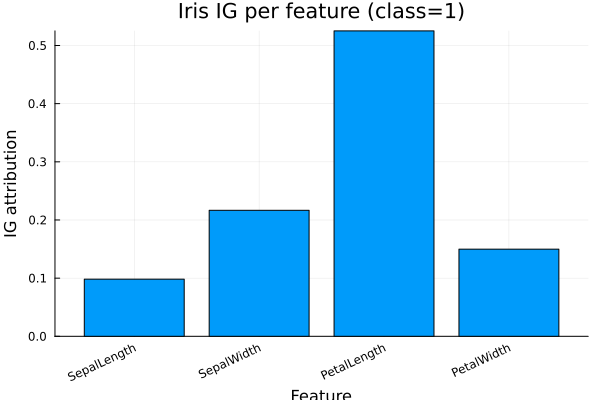

In [18]:
# ==========================================================
# Iris Demo: Train an MLP (your Chain) + IG explanation
# ==========================================================
using Random, Statistics
import Pkg

# Load Iris dataset from RDatasets (auto install if missing)
try
    using RDatasets
catch
    Pkg.add("RDatasets")
    using RDatasets
end

# Plotting library
try
    using Plots
catch
    Pkg.add("Plots")
    using Plots
end

# ---- Load data ----
iris = dataset("datasets", "iris")  # 150 samples × 5 columns

X_raw = Array{Float64}(Matrix(iris[:, 1:4]))  # Features: (150, 4)
species = Vector(iris[:, 5])                  # Labels: 150 strings

# Create class-to-index mappings
classes = unique(species)
class_to_id = Dict(classes[i] => i for i in 1:length(classes))  # String -> 1..3
id_to_class = Dict(i => classes[i] for i in 1:length(classes))  # 1..3 -> String
y_id = [class_to_id[s] for s in species]  # Convert all labels to integers

N = size(X_raw, 1)  # Total samples
C = length(classes)  # Number of classes

# One-hot encode labels: shape (C, N)
Y = zeros(Float64, C, N)
for i in 1:N
    Y[y_id[i], i] = 1.0
end

# ---- Train/test split ----
Random.seed!(42)
perm = randperm(N)
train_n = 120
train_idx = perm[1:train_n]
test_idx = perm[train_n+1:end]

X_train = X_raw[train_idx, :]
X_test = X_raw[test_idx, :]

Y_train = Y[:, train_idx]
Y_test = Y[:, test_idx]

y_train_id = y_id[train_idx]
y_test_id = y_id[test_idx]

# ---- Standardize features using training set statistics ----
μ = mean(X_train, dims=1)
σ = std(X_train, dims=1) .+ 1e-12  # Small epsilon to avoid division by zero

X_train = (X_train .- μ) ./ σ
X_test = (X_test .- μ) ./ σ

# ---- Build model: 4 inputs -> 16 hidden -> 3 output logits ----
mlp_iris = Chain(
    Linear(4, 16),
    ReLU(),
    Linear(16, 3)
)

# ---- Loss function: MSE on logits (simple for from-scratch implementation) ----
function mse_loss_logits(logits::Tensor, y_onehot::Array{Float64})
    y = Tensor(y_onehot, _op="Y")
    diff = logits - y
    sq = mul_elem(diff, diff)  # Element-wise square
    return sum(sq) / length(y_onehot)  # Mean squared error (scalar)
end

# ---- Predict class ID for a single sample ----
function predict_id(model::Chain, x_col::Array{Float64})
    out = model(Tensor(x_col, _op="Input"))  # Forward pass -> (3,1)
    _, idx = findmax(vec(out.data))          # Argmax
    return idx
end

# ---- Compute accuracy over dataset ----
function accuracy(model::Chain, Xmat::Array{Float64,2}, y_ids::Vector{Int})
    n = size(Xmat, 1)
    correct = 0
    for i in 1:n
        x_col = reshape(Xmat[i, :], :, 1)  # Reshape row to column (4,1)
        pred = predict_id(model, x_col)
        correct += (pred == y_ids[i])
    end
    return correct / n
end

# ---- Single mini-batch training step ----
function batch_step!(model::Chain, Xb::Array{Float64}, Yb::Array{Float64}; lr=0.02)
    # Xb: (input_dim, batch_size), Yb: (num_classes, batch_size)
    xt = Tensor(Xb, _op="Input")
    logits = model(xt)                       # Forward pass -> (C, B)
    loss = mse_loss_logits(logits, Yb)       # Compute loss (scalar)

    # Reset gradients before backward pass
    zero_grad!(model)
    xt.grad .= 0.0
    backward(loss)

    # SGD parameter update
    for layer in model.layers
        if layer isa Linear
            layer.W.data .-= lr .* layer.W.grad
            layer.b.data .-= lr .* layer.b.grad
        end
    end

    return loss.data[1, 1]
end

# ---- Training loop (mini-batch SGD) ----
epochs = 80
lr = 0.03
batch_size = 16

# Transpose for column-major batching: Xtr = (4, 120), Ytr = (3, 120)
Xtr = permutedims(X_train)
Ytr = Y_train

for ep in 1:epochs
    order = randperm(size(Xtr, 2))  # Shuffle sample indices
    total = 0.0

    # Iterate over mini-batches
    for start in 1:batch_size:length(order)
        idxs = order[start:min(start + batch_size - 1, end)]
        Xb = Xtr[:, idxs]
        Yb = Ytr[:, idxs]
        total += batch_step!(mlp_iris, Xb, Yb; lr=lr)
    end

    # Log progress every 10 epochs
    if ep % 10 == 0 || ep == 1
        acc_tr = accuracy(mlp_iris, X_train, y_train_id)
        acc_te = accuracy(mlp_iris, X_test, y_test_id)
        println("Epoch $(lpad(ep,2)) | loss(sum batches)=$(round(total, digits=6)) | acc(train)=$(round(acc_tr, digits=3)) | acc(test)=$(round(acc_te, digits=3))")
    end
end

println("\nClass mapping:")
for i in 1:C
    println("  $i => ", id_to_class[i])
end

# ---- IG Explanation: Pick a test sample and compute attributions ----
feat_names = ["SepalLength", "SepalWidth", "PetalLength", "PetalWidth"]

sample_i = 1  # Select sample index from 1..length(test_idx)
x = reshape(X_test[sample_i, :], :, 1)  # Standardized input (4,1)
x0 = zeros(4, 1)                        # Zero baseline

pred = predict_id(mlp_iris, x)
target_class = pred  # Explain the predicted class

# Compute Integrated Gradients
attrs = integrated_gradients(mlp_iris, x, x0; steps=200, target=target_class, method=:ad)
vals = vec(attrs)

println("\n=== Iris IG (AD) ===")
println("Test sample index: ", sample_i)
println("Predicted class id: ", target_class, " => ", id_to_class[target_class])
println("Per-feature IG:")
for k in 1:4
    println(rpad(feat_names[k], 12), "  IG = ", round(vals[k], digits=6))
end

# Completeness check: sum(IG) should approximate logit(x) - logit(x0)
function target_logit(model::Chain, x_num::Array{Float64}, cls::Int)
    out = model(Tensor(x_num, _op="Input"))
    return out.data[cls, 1]
end

fx = target_logit(mlp_iris, x, target_class)
fx0 = target_logit(mlp_iris, x0, target_class)
println("\nCompleteness check:")
println("F(x)  = ", fx)
println("F(x0) = ", fx0)
println("ΔF    = ", fx - fx0)
println("sum(IG)= ", sum(attrs))
println("abs error = ", abs(sum(attrs) - (fx - fx0)))

# Visualize attributions as bar chart
bar(feat_names, vals;
    legend=false,
    xrotation=25,
    title="Iris IG per feature (class=$(target_class))",
    xlabel="Feature",
    ylabel="IG attribution")

### 4. Supplement Missing Operators (Power, Inverse, Division, Scalar Mul)
To support physical formula calculations, we need to define additional operators: `^` (power), `inv`, `1/x`, and scalar multiplication `t * n`.

In [19]:
import Base: ^, inv, *, /

# --- Pow (x^n): Integer power operation ---
function ^(t::Tensor, n::Int)
    out = Tensor(t.data .^ n, _children=(t,), _op="Pow$n")
    function _backward()
        # d(x^n)/dx = n * x^(n-1)
        t.grad .+= (n .* (t.data .^ (n-1))) .* out.grad
    end
    out._backward = _backward
    return out
end

# --- Inv (1/x): Element-wise inverse ---
function inv(t::Tensor)
    out = Tensor(1.0 ./ t.data, _children=(t,), _op="Inv")
    function _backward()
        # d(1/x)/dx = -1/x^2
        t.grad .+= (-1.0 ./ (t.data .^ 2)) .* out.grad
    end
    out._backward = _backward
    return out
end

# --- Division (Number / Tensor): Scalar divided by tensor ---
function /(a::Number, b::Tensor)
    # Rewrite as multiplication with inverse: a/b = a * (1/b)
    return a * inv(b)
end

# --- Multiplication (Tensor * Number): Commutative wrapper ---
# Fixes MethodError: no method matching *(::Tensor, ::Float64)
function *(t::Tensor, n::Number)
    # Delegate to Number * Tensor for consistent implementation
    return n * t
end

# --- Multiplication (Number * Tensor): Scalar times tensor ---
function *(n::Number, t::Tensor)
    out = Tensor(n .* t.data, _children=(t,), _op="MulScalar")
    function _backward()
        # d(n*x)/dx = n
        t.grad .+= n .* out.grad
    end
    out._backward = _backward
    return out
end

* (generic function with 415 methods)

### 5. Accuracy Benchmark: Custom AD vs ForwardDiff Error
Verify the accuracy of our automatic differentiation engine on $f(x) = \sin(x) \cdot x$.
Compare the error gap between **|Custom_AD - Analytic|** and **|ForwardDiff - Analytic|**.

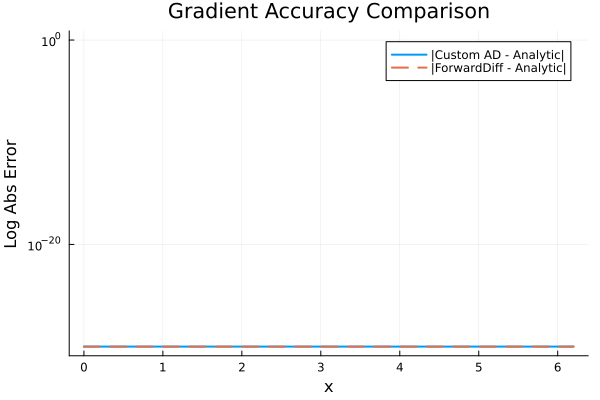

In [20]:
# 5. Accuracy Benchmark: Custom AD Error vs ForwardDiff Error
# Purpose: Compare our Custom AD against Julia's standard differentiation library (ForwardDiff)
#          relative to the analytical solution.
# Expected: Both errors should be near machine precision (1e-15 ~ 1e-16).

# 5.1 Define test function f(x) = sin(x) * x
# Custom AD version (uses our Tensor type)
function test_fun(x::Tensor)
    return sin(x) * x
end

# Standard Julia function for ForwardDiff and analytical comparison
f_jul(x) = sin(x) * x

# 5.2 Analytical gradient: f'(x) = cos(x)*x + sin(x) (product rule)
analytic_grad(x) = cos(x)*x + sin(x)

# 5.3 Comparison
# Ensure ForwardDiff is installed
try using ForwardDiff catch; import Pkg; Pkg.add("ForwardDiff"); using ForwardDiff end

x_vals = collect(0.0:0.1:2π)  # Test points from 0 to 2π
err_custom_ad = Float64[]
err_forwarddiff = Float64[]

for val in x_vals
    # 1. Custom AD gradient calculation
    t = Tensor(val, _op="x")
    y = test_fun(t)
    backward(y)
    grad_custom = t.grad[1]
    
    # 2. ForwardDiff gradient calculation
    grad_fd = ForwardDiff.derivative(f_jul, val)
    
    # 3. Ground truth from analytical formula
    truth = analytic_grad(val)
    
    # 4. Compute absolute errors
    push!(err_custom_ad, abs(grad_custom - truth))
    push!(err_forwarddiff, abs(grad_fd - truth))
end

# 5.4 Plot comparison (add tiny offset to avoid log(0))
plot(x_vals, err_custom_ad .+ 1e-30, label="|Custom AD - Analytic|", yaxis=:log, 
     title="Gradient Accuracy Comparison", xlabel="x", ylabel="Log Abs Error", lw=2)
plot!(x_vals, err_forwarddiff .+ 1e-30, label="|ForwardDiff - Analytic|", lw=2, linestyle=:dash)

### 6. Real-world Example: Netball Robot Optimization
**Target**: Optimize initial velocity $v$ and angle $\theta$ so the ball hits the hoop at $(0, h)$.
**Loss**: $\mathcal{L}(v, \theta) = |y(T) - h|^2 + \alpha |v|^2$

Starting Netball Optimization (Custom AD) (Initial: v=10, θ=0)...
Iter 500: Loss=1.0647, v=20.391, θ=17.719
Iter 1000: Loss=0.1489, v=22.26, θ=25.518
Iter 1500: Loss=0.0157, v=22.862, θ=28.474
Iter 2000: Loss=0.0014, v=23.048, θ=29.434
Iter 2500: Loss=0.0001, v=23.103, θ=29.724
Iter 3000: Loss=0.0, v=23.12, θ=29.81
Optimization Finished: Final v=23.1198, θ=29.8099


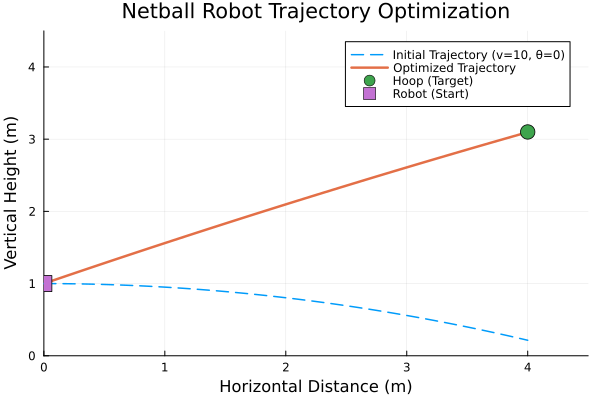

In [34]:
using Plots

# 1. Physics Parameters
const Y0_ROBOT = 1.0
const H_HOOP = 3.1
const D_DIST = 4.0
const G_GRAV = -9.81

# 2. Loss Function (Tensor input): p is 2x1 Tensor: p[1,1]=v, p[2,1]=theta_deg
function netball_loss(p::Tensor)
    v = p[1, 1]
    theta_deg = p[2, 1]

    theta_rad = theta_deg * (π / 180.0)

    term1 = Y0_ROBOT
    term2 = D_DIST * tan(theta_rad)
    term3 = (0.5 * G_GRAV * D_DIST^2) / (v^2 * cos(theta_rad)^2)

    h_pred = term1 + term2 + term3
    return (h_pred - H_HOOP)^2   # scalar Tensor
end

# 3. Optimization Loop (custom AD)
function optimize_shot(; steps=3000, lr=0.15)
    # p is 2x1 Tensor: [v; theta_deg]
    p = Tensor(reshape([10.0, 0.0], 2, 1), _op="p", requires_grad=true)

    println("Starting Netball Optimization (Custom AD) (Initial: v=10, θ=0)...")

    for i in 1:steps
        # forward
        L = netball_loss(p)

        # backward
        backward_iterative(L)

        # gradient descent update
        p.data .-= lr .* p.grad

        # clear grad for next iter (safe even if backward_iterative already zeros)
        p.grad .= 0.0

        if i % 500 == 0
            loss_val = L.data isa Number ? float(L.data) : float(L.data[1])
            println("Iter $i: Loss=$(round(loss_val, digits=4)), v=$(round(p.data[1], digits=3)), θ=$(round(p.data[2], digits=3))")
        end
    end

    return p.data[1], p.data[2]
end

# 4. Trajectory for visualization (keep numeric)
function get_traj(v, deg)
    rad = deg * π / 180.0
    T = D_DIST / (v * cos(rad))
    ts = range(0, T, length=100)
    xs = [v * cos(rad) * t for t in ts]
    ys = [Y0_ROBOT + v * sin(rad) * t + 0.5 * G_GRAV * t^2 for t in ts]
    return xs, ys
end

# --- Execution ---
v_opt, theta_opt = optimize_shot()
println("Optimization Finished: Final v=$(round(v_opt, digits=4)), θ=$(round(theta_opt, digits=4))")

# --- Plotting ---
x_init, y_init = get_traj(10.0, 0.0)
x_opt, y_opt = get_traj(v_opt, theta_opt)

plt = plot(x_init, y_init, label="Initial Trajectory (v=10, θ=0)", linestyle=:dash, lw=1.5)
plot!(plt, x_opt, y_opt, label="Optimized Trajectory", lw=2.5)
scatter!(plt, [D_DIST], [H_HOOP], label="Hoop (Target)", markersize=8, marker=:circle)
scatter!(plt, [0.0], [Y0_ROBOT], label="Robot (Start)", markersize=8, marker=:square)

title!("Netball Robot Trajectory Optimization")
xlabel!("Horizontal Distance (m)")
ylabel!("Vertical Height (m)")
xlims!(0, 4.5)
ylims!(0, 4.5)
display(plt)


### 7. Explainability: Velocity vs Angle?
**Integrated Gradients** analysis.


=== Netball Explainability ===
Baseline: v=15, θ=45
Optimal:  v=23.12, θ=29.81
Attributions (v, θ): [0.5219, -1.9556]


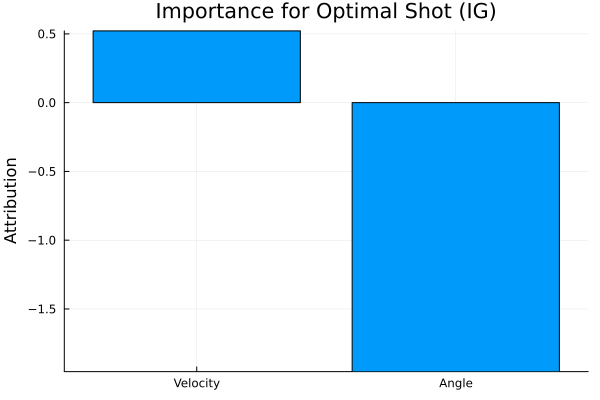

In [36]:
# Multi-dimensional input for IG: use the optimized params as a 2x1 array
p_opt = reshape([v_opt, theta_opt], 2, 1)

# Baseline: reasonable initial guess (v=15 m/s, theta=45 degrees)
baseline_p = reshape([15.0, 45.0], 2, 1)

# Compute Integrated Gradients (custom AD)
attrs_netball = integrated_gradients(netball_loss, p_opt, baseline_p; steps=100, method=:ad)

println("\n=== Netball Explainability ===")
println("Baseline: v=15, θ=45")
println("Optimal:  v=$(round(v_opt,digits=2)), θ=$(round(theta_opt,digits=2))")
println("Attributions (v, θ): ", vec(round.(attrs_netball, digits=4)))

# Visualize which parameter contributes more
bar(["Velocity", "Angle"], vec(attrs_netball),
    title="Importance for Optimal Shot (IG)",
    ylabel="Attribution",
    legend=false)
